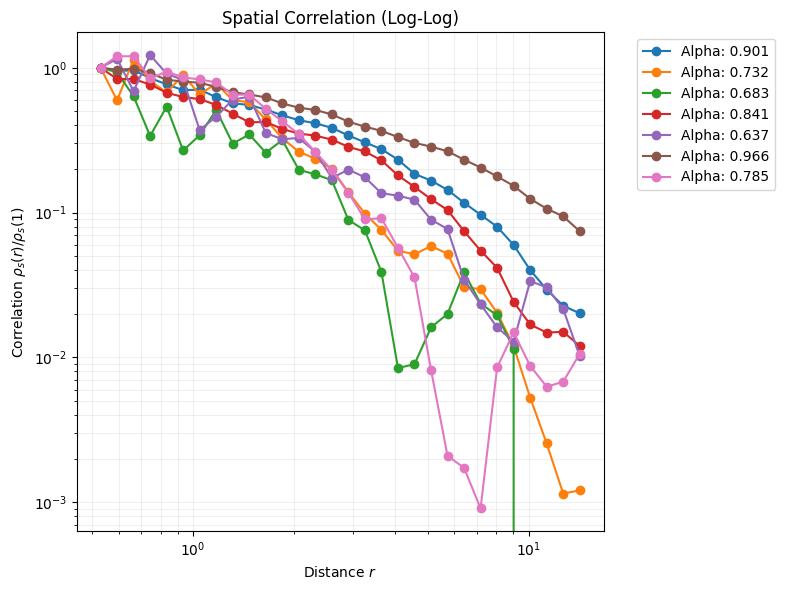

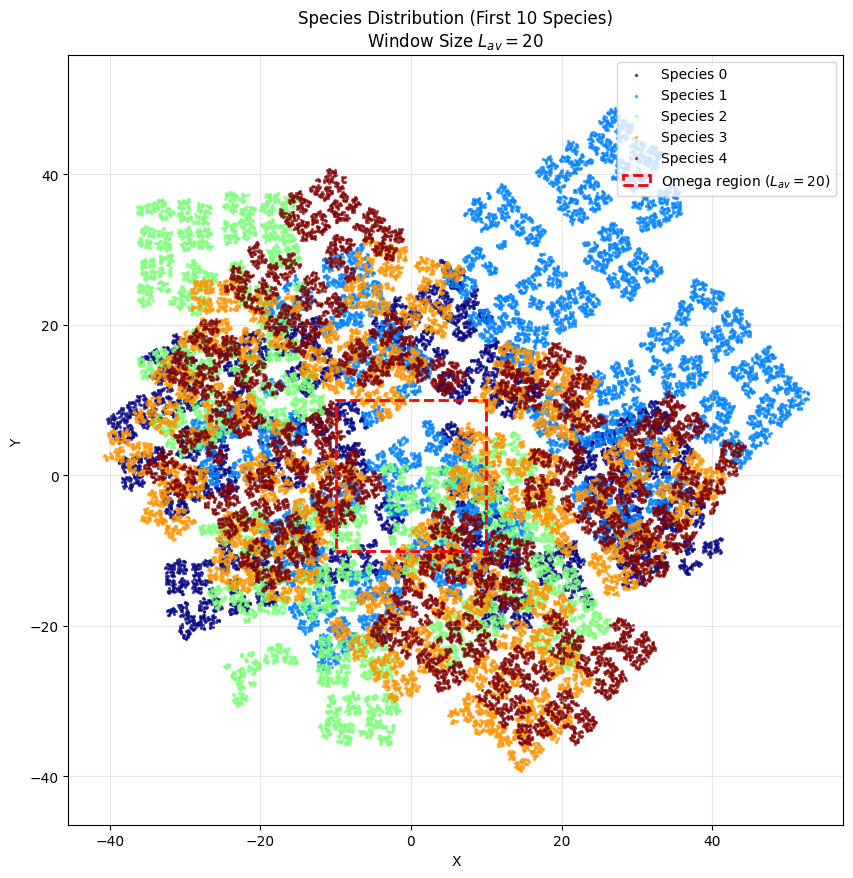

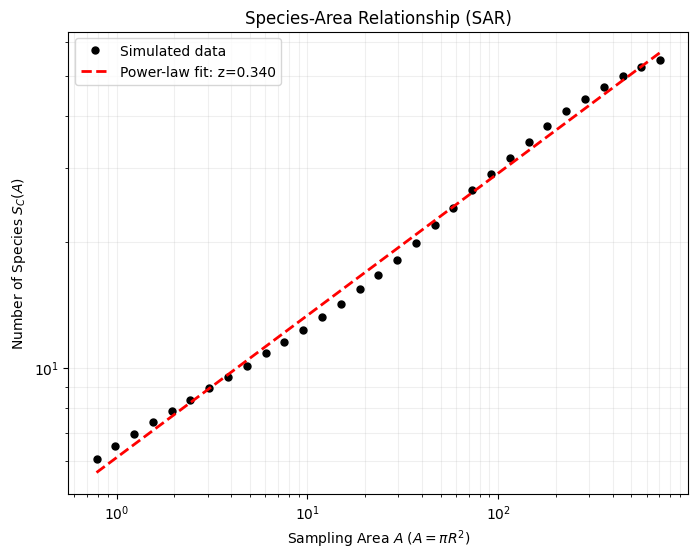

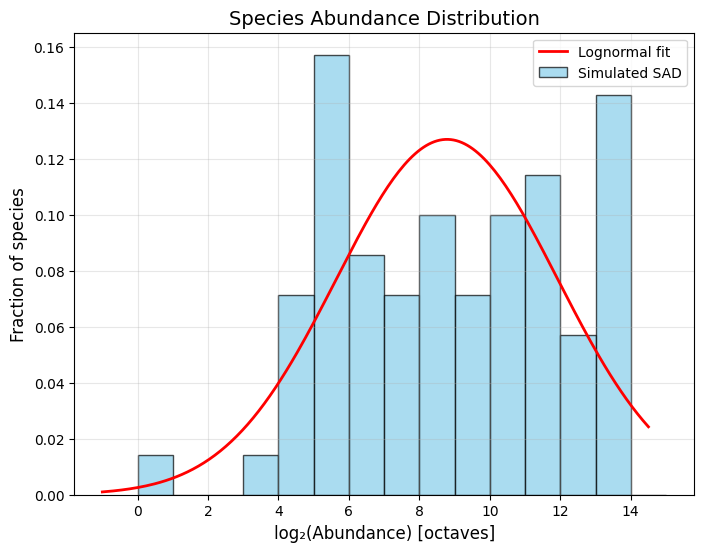

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x110eddfa0>>
Traceback (most recent call last):
  File "/Users/tadhgjones/.julia/conda/3/x86_64/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [ ]:
from enum import Enum
import json
import numpy as np
from matplotlib import patches, pyplot as plt
from scipy.stats import norm
from scipy import stats
from sklearn.neighbors import KDTree
from collections import Counter
from scipy.optimize import curve_fit
from scipy.spatial import cKDTree

class Branch(Enum):
    """
    How to branch for the population.
    """
    LEFT = 1
    RIGHT = 2
    BOTH = 4

class Individual:
    """
    X Y coordinates of an individual.
    """
    def __init__(self, x: float, y: float, theta: float, species_id: int = None, comp: float = 1.0):
        """
        Initialise a position for an individual.
        
        :param x: X coordinate of the individual
        :type x: float
        :param y: Y coordinate of the individual
        :type y: float
        """
        self.x = x
        self.y = y
        self.theta = theta
        self.species_id = species_id
        self.comp = comp

class Field:
    """
    Container for different individuals with competition.
    """
    def __init__(
        self,
        species_alpha: list[float],
        m: int,
        l: float,
        delta0: float,
        delta_diff: float,
        d: float,
        L_av: int,
        comp_values: list[float] = None  # competition coefficients
    ):
        """
        Initialise an area with branching species.

        :param species_alpha: Alpha parameter for each species
        :param m: Maximum number of branching iterations
        :param l: Starting branch length
        :param delta0: Initial delta angle
        :param delta_diff: Delta change factor
        :param d: Maximum initial point diameter
        :param L_av: Averaging area side length
        :param comp_values: Competition coefficient per species
        """
        assert m > 0 and l > 0 and d > 0
        self.species_alpha = species_alpha
        self.m = m
        self.l = l
        self.delta0 = delta0
        self.delta_diff = delta_diff
        self.d = d
        self.L_av = L_av
        self.omega_range = L_av / 2

        if comp_values is None:
            comp_values = [1.0] * len(species_alpha) # Initially no competition

        self.points = dict()
        previous_alpha = None
        count = 0
        species_id = 0  # global species counter

        for alpha in self.species_alpha:
            if alpha == previous_alpha:
                count += 1
            else:
                previous_alpha = alpha
                count = 0

            key = f"{alpha}-{count}"
            species_inds = self.generate_species(alpha)

            # assign species_id and competition coefficient
            for ind in species_inds:
                ind.species_id = species_id
                ind.comp = comp_values[species_id]

            self.points[key] = species_inds
            species_id += 1

    def generate_species(self, alpha: float) -> list:
        """Generate a species with a given alpha parameter."""
        branch_options = [Branch.LEFT, Branch.RIGHT, Branch.BOTH]
        p = [1 - alpha, 1 - alpha, 2*alpha - 1]

        # initial point
        theta0 = np.random.uniform(0, 2*np.pi)
        r0 = self.get_initial_point()
        x = np.array([r0.x])
        y = np.array([r0.y])
        thetas = np.array([theta0])

        l0 = self.l
        for n in range(1, self.m+1):
            l = l0 * 1.5**(-(n-1))
            delta_max = self.delta0 * (self.delta_diff)**(2*(n//2)/self.m)
            point_count = len(x)

            deltas = np.random.uniform(-delta_max, delta_max, point_count)
            new_thetas = thetas + deltas + np.pi/2
            branches = np.random.choice(branch_options, p=p, size=point_count)

            left = (branches == Branch.LEFT) | (branches == Branch.BOTH)
            right = (branches == Branch.RIGHT) | (branches == Branch.BOTH)

            left_x = x[left] + l * np.cos(new_thetas[left])
            left_y = y[left] + l * np.sin(new_thetas[left])
            right_x = x[right] + l * np.cos(new_thetas[right] + np.pi)
            right_y = y[right] + l * np.sin(new_thetas[right] + np.pi)

            x = np.concatenate([left_x, right_x])
            y = np.concatenate([left_y, right_y])
            thetas = np.concatenate([new_thetas[left], new_thetas[right]])

        return [Individual(x_, y_, th_) for x_, y_, th_ in np.stack([x, y, thetas], axis=-1)]

    def get_initial_point(self) -> Individual:
        """Create the initial point for a tree."""
        offset = np.random.rand() * self.d
        radian = np.random.rand() * 2*np.pi
        return Individual(offset*np.cos(radian), offset*np.sin(radian), 0)

    def species_area_curve(self, R_values: np.ndarray, n_samples: int = 1000) -> np.ndarray:
        """Compute Species-Area Relationship S_C(R) using sample points."""
        S_C = np.zeros_like(R_values, dtype=float)
        max_R = R_values.max()
        sample_x = np.random.uniform(-self.omega_range + max_R, self.omega_range - max_R, n_samples)
        sample_y = np.random.uniform(-self.omega_range + max_R, self.omega_range - max_R, n_samples)
        sample_points = np.column_stack([sample_x, sample_y])

        for species in self.points.values():
            if not species:
                continue
            points_array = np.array([(p.x, p.y) for p in species])
            tree = KDTree(points_array)
            dists, _ = tree.query(sample_points)
            dists = dists.ravel()
            proximity_matrix = dists[:, None] <= R_values[None, :]
            S_C += np.mean(proximity_matrix, axis=0)
        return S_C

    def compute_correlation_function(self, species: list, r_bins: np.ndarray) -> np.ndarray:
        """Compute correlation function for a species."""
        points_in_omega = [p for p in species if -self.omega_range <= p.x <= self.omega_range and -self.omega_range <= p.y <= self.omega_range]
        if len(points_in_omega) < 2:
            return np.zeros(len(r_bins)-1)
        points_array = np.array([(p.x, p.y) for p in points_in_omega])
        n = len(points_array)
        dx = points_array[:, None, 0] - points_array[None, :, 0]
        dy = points_array[:, None, 1] - points_array[None, :, 1]
        dist_matrix = np.sqrt(dx**2 + dy**2)
        d_flat = dist_matrix[np.triu_indices(n, k=1)]
        counts, _ = np.histogram(d_flat, bins=r_bins)
        r_inner = r_bins[:-1]
        r_outer = r_bins[1:]
        bin_areas = np.pi * (r_outer**2 - r_inner**2)
        rho_raw = np.nan_to_num(counts / bin_areas)
        return rho_raw / rho_raw[0] if rho_raw[0] > 0 else np.zeros_like(rho_raw)

    def get_correlations_grouped_by_alpha(self, r_bins: np.ndarray) -> dict:
        """Return average correlation per alpha group."""
        grouped_results = {}
        unique_alphas = list(set(key.split("-")[0] for key in self.points.keys()))
        for target_alpha in unique_alphas:
            correlations = []
            for key, species in self.points.items():
                if key.split("-")[0] == target_alpha:
                    rho = self.compute_correlation_function(species, r_bins)
                    if np.sum(rho) > 0:
                        correlations.append(rho)
            grouped_results[float(target_alpha)] = np.mean(correlations, axis=0) if correlations else None
        return grouped_results
    
    def ind_resource_species(self, ind, all_inds, Res, radius):
        """ Compute the resource intake for an individual using KDTree for neighbors """
        # Build KDTree for all individual positions
        points_array = np.array([[i.x, i.y] for i in all_inds])
        tree = cKDTree(points_array)

        # Query neighbors within radius (includes the individual itself)
        idxs = tree.query_ball_point([ind.x, ind.y], r=radius)
        idxs.remove(all_inds.index(ind))  # remove self

        if idxs:
            total_comp = sum(all_inds[i].comp for i in idxs)
        else:
            total_comp = 0.0

        # Clip indices to grid
        x_idx = int(np.clip(ind.x, 0, Res.shape[0]-1))
        y_idx = int(np.clip(ind.y, 0, Res.shape[1]-1))

        available = Res[x_idx, y_idx]
        return available / (1 + total_comp)

    def species_richness_grid(self, surviving_inds, grid_size, Lx, Ly):
        richness = []
        for i in range(0, Lx, grid_size):
            for j in range(0, Ly, grid_size):
                sub = [
                    ind for ind in surviving_inds
                    if i <= ind.x < i + grid_size and j <= ind.y < j + grid_size
                ]
                richness.append(len(set(ind.species_id for ind in sub)))
        return np.array(richness)

    def power_law(self, A, c, z):
        return c * A**z
    
def main():
    t = [-0.05, -0.15, -0.25, -0.35, -0.45, -0.55, -0.65]
    alpha_values = list(map(lambda o: 2**o, t))
    #alpha_values = np.linspace(0.60, 0.97, 5)[::-1]
    # alpha_values = [0.72,0.76,0.8]
    species_alpha = [o for o in alpha_values for i in range(10)]
    
    grid = Field(
    species_alpha=species_alpha,   
    m=14,
    l=20,
    delta0=0.1,
    delta_diff=8,
    d=15,
    L_av=20,
    comp_values=None)
    
    r_min = 0.5
    r_max = 15
    num_bins = 30 
    R_values = np.logspace(np.log10(r_min), np.log10(r_max), num_bins + 1)

    # plot correlation functions
    results_corr_dict = grid.get_correlations_grouped_by_alpha(R_values)

    plt.figure(figsize=(8, 6))
    for alpha, rho_avg in results_corr_dict.items():
        if rho_avg is not None:
            r_centers = (R_values[:-1] + R_values[1:]) / 2
            plt.plot(r_centers, rho_avg, marker='o', label=f'Alpha: {alpha:.3f}')
    
    plt.xscale('log')
    plt.yscale('log') 
    plt.xlabel(r'Distance $r$')
    plt.ylabel(r'Correlation $\rho_s(r) / \rho_s(1)$')
    plt.title('Spatial Correlation (Log-Log)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.tight_layout()
    plt.show()

    # plot species distribution (first 5 species)
    plt.figure(figsize=(10, 10))
    colors = plt.cm.jet(np.linspace(0, 1, 5))

    unique_alphas = sorted(list(set([key.split("-")[0] for key in grid.points.keys()])))
    alpha_index= -1 #len(unique_alphas) // 2 # here middle alpha
    alpha = unique_alphas[alpha_index]
    
    for i in range(5):
        species_key = f"{alpha}-{i}"
        if species_key in grid.points:
            species = grid.points[species_key]
            xs = [p.x for p in species]
            ys = [p.y for p in species]
            plt.scatter(xs, ys, s=2, alpha=0.6, label=f'Species {i}', color=colors[i])

    # omega box
    omega_range = grid.omega_range
    rect = patches.Rectangle(
        (-omega_range, -omega_range),  
        2 * omega_range,                # width
        2 * omega_range,                # height
        linewidth=2,
        edgecolor='red',
        facecolor='none',
        linestyle='--',
        label=f'Omega region ($L_{{av}}={grid.L_av}$)'
    )
    ax = plt.gca()
    ax.add_patch(rect)
    plt.title(f"Species Distribution (First 10 Species)\nWindow Size $L_{{av}}={grid.L_av}$")
    plt.xlabel("X")
    plt.ylabel("Y ")
    plt.axis('equal') 
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.show()

    # plot Species-Area Relationship
    S_values = grid.species_area_curve(R_values, n_samples=2000)
    # get area from radius
    A_values = np.pi * (R_values ** 2)
    
    log_A = np.log10(A_values)
    log_S = np.log10(S_values)
    size = int(len(log_S))
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_A[:size], log_S[:size])
    # obtained power law 
    plt.figure(figsize=(8, 6))
    plt.loglog(A_values, S_values, 'o', 
               color='black', markersize=5, label='Simulated data')
    # fit line for slope
    fit_line = 10**intercept * A_values**slope
    plt.loglog(A_values, fit_line, 'r--', linewidth=2,
               label=f'Power-law fit: z={slope:.3f}')
    
    plt.xlabel(r"Sampling Area $A$ ($A = \pi R^2$)")
    plt.ylabel(r"Number of Species $S_C(A)$")
    plt.title("Species-Area Relationship (SAR)")
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend()
    plt.show()

    # plot lognormal distribution of abundance
    plt.figure(figsize=(8, 6))
    # get abundances
    abundances = np.array([len(species) for species in grid.points.values()])
    abundances = abundances[abundances > 0]
    # octave bins
    max_abundance = max(abundances)
    num_octaves = int(np.ceil(np.log2(max_abundance))) + 1
    bins = [2**i for i in range(num_octaves + 1)]
    
    counts, bin_edges = np.histogram(abundances, bins=bins)
    fractions = counts / counts.sum()
    octave_centers = np.log2(np.sqrt(bin_edges[:-1] * bin_edges[1:]))
    
    # fit lognormal distribution
    log2_abundances = np.log2(abundances)
    mu_log2 = log2_abundances.mean()
    sigma_log2 = log2_abundances.std()
    x_log2 = np.linspace(log2_abundances.min() - 1, log2_abundances.max() + 1, 200)
    normal_pdf = norm.pdf(x_log2, mu_log2, sigma_log2)
    bin_width = np.mean(np.diff(octave_centers)) if len(octave_centers) > 1 else 1.0
    normal_pdf_scaled = normal_pdf * bin_width

    plt.bar(octave_centers, fractions, width=1,
            alpha=0.7, color='skyblue', edgecolor='black', 
            label='Simulated SAD')
    plt.plot(x_log2, normal_pdf_scaled, 'r-', linewidth=2,
             label=f'Lognormal fit')
    plt.xlabel('log₂(Abundance) [octaves]', fontsize=12)
    plt.ylabel('Fraction of species', fontsize=12)
    plt.title('Species Abundance Distribution', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # SAR competition simulation
    Lx, Ly = 200, 200
    n_species = 20
    radius = 1.0
    threshold_intake = 0.1
    n_runs = 10
    grid_sizes = [20, 40]

    # Log-spaced competition coefficients
    total_species = len(species_alpha)
    comp_values = np.logspace(-2, 1, total_species)

    SAR_runs = []
    for run in range(n_runs):
        # Generate resource field
        Res = np.random.gamma(shape=2.0, scale=1.0, size=(Lx, Ly))

        # Generate branching field
        field = Field(
            species_alpha=species_alpha,
            m=14,
            l=20,
            delta0=0.1,
            delta_diff=8,
            d=15,
            L_av=20,
            comp_values=comp_values
        )

        # Flatten all individuals
        all_inds = [ind for species in field.points.values() for ind in species]

        # Rescale coords for resource comp
        xs = np.array([ind.x for ind in all_inds])
        ys = np.array([ind.y for ind in all_inds])
        x_range = xs.max() - xs.min()
        y_range = ys.max() - ys.min()

        xs_rescaled = (xs - xs.min()) / x_range * (Lx-1) if x_range != 0 else np.full_like(xs, Lx/2)
        ys_rescaled = (ys - ys.min()) / y_range * (Ly-1) if y_range != 0 else np.full_like(ys, Ly/2)

        for i, ind in enumerate(all_inds):
            ind.x = xs_rescaled[i]
            ind.y = ys_rescaled[i]
            ind.comp = comp_values[ind.species_id % n_species] # Assign comp value based on species id

        # Compute survival
        surviving_inds = []
        for ind in all_inds:
            intake = field.ind_resource_species(ind, all_inds, Res, radius)
            if intake >= threshold_intake:
                surviving_inds.append(ind)

        # Compute SAR with resource comp
        SAR_run = []
        for gs in grid_sizes:
            richness = field.species_richness_grid(surviving_inds, gs, Lx, Ly)
            SAR_run.append(np.mean(richness))
        SAR_runs.append(SAR_run)

    SAR_runs = np.array(SAR_runs)
    SAR_mean = SAR_runs.mean(axis=0)
    SAR_std = SAR_runs.std(axis=0)

    # Fit power law
    params, _ = curve_fit(field.power_law, np.array(grid_sizes), SAR_mean, p0=[1, 0.2])
    c_fit, z_fit = params
    print(f"Fitted SAR: S = {c_fit:.2f} * A^{z_fit:.2f}")

    # Plot SAR with competition
    plt.figure(figsize=(8,6))
    plt.errorbar(grid_sizes, SAR_mean, yerr=SAR_std, fmt='o', capsize=5, label='Mean SAR ± SD')
    plt.loglog(grid_sizes, field.power_law(np.array(grid_sizes), *params), '-', label=f'Fit (z={z_fit:.2f})')
    plt.xlabel("Area")
    plt.ylabel("Mean species richness")
    plt.title("Species–Area Relationship with Branching & Competition")
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

if __name__ == "__main__":
    main()

